# Credit scoring model


# **Objective:**  

Develop a credit scoring model that can assess the creditworthiness of borrowers based on a range of factors, such as income, employment history, and debt-to-income ratio

# **Imports**

In [1]:
import numpy as np
import pandas as pd
import itertools
from scipy.stats import loguniform

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import catboost
import lightgbm as lgb
from sklearn import tree
from sklearn.feature_selection import chi2, SelectKBest, f_classif, f_regression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
credits = pd.read_csv("hmeq.csv")
credits.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
credits.shape

(5960, 13)

In [4]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [5]:
credits.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [6]:
credits["BAD"].value_counts().values

array([4771, 1189])

We can observe an imbalance in the class.

0    4771
1    1189
Name: BAD, dtype: int64


<Axes: >

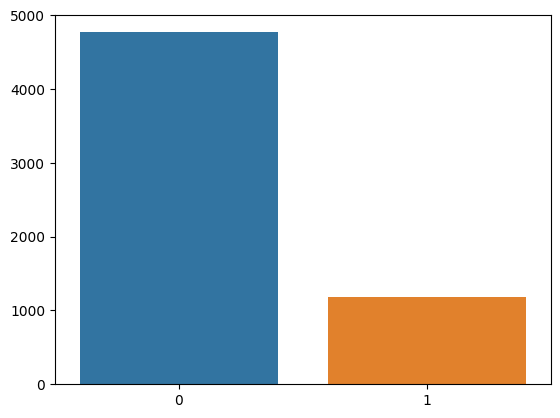

In [7]:
print(credits["BAD"].value_counts())
sns.barplot(data=credits, x=credits["BAD"].value_counts().index, y=credits["BAD"].value_counts().values)

<Axes: >

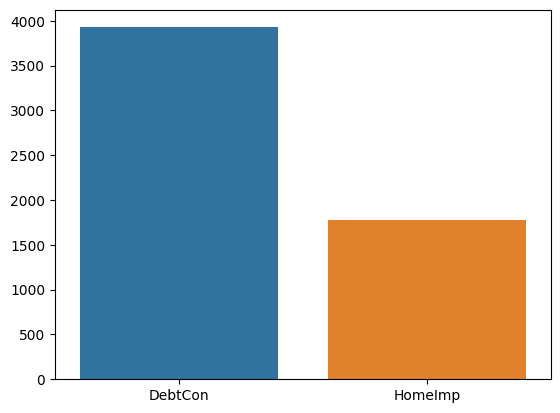

In [8]:
sns.barplot(data=credits, x=credits["REASON"].value_counts().index, y=credits["REASON"].value_counts().values)
# Nominal feature, we will transform it before entering the modelling part.

<Axes: >

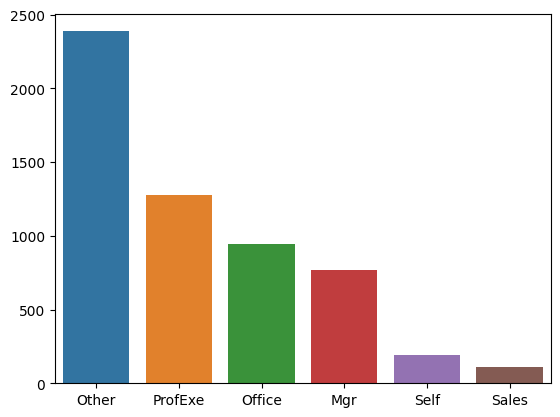

In [9]:
sns.barplot(data=credits, x=credits["JOB"].value_counts().index, y=credits["JOB"].value_counts().values)
# Same as above

<Axes: ylabel='Frequency'>

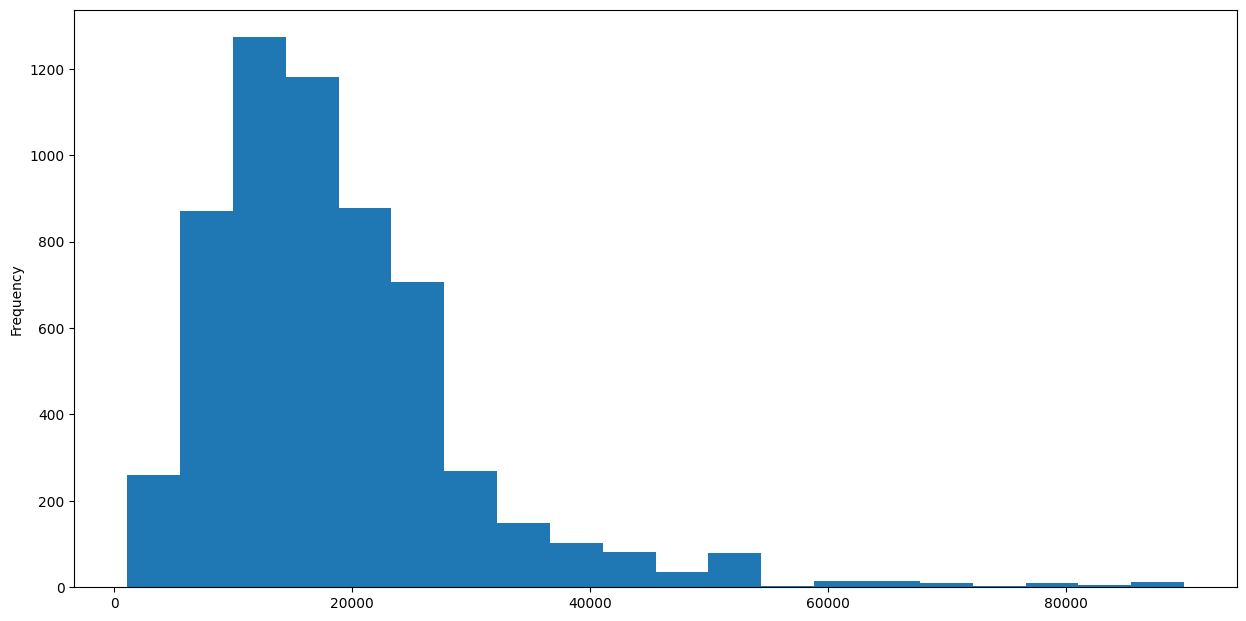

In [10]:
credits["LOAN"].plot.hist(bins = 20,figsize=(15,7.5))
# Most values are between 10 000 and 30 000

<Axes: ylabel='Frequency'>

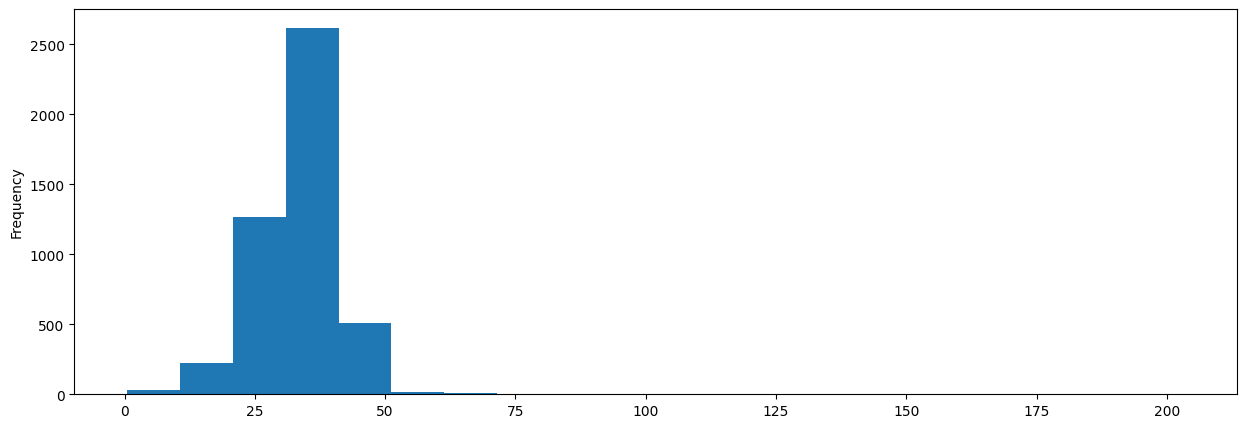

In [11]:
credits["DEBTINC"].plot.hist(bins = 20,figsize=(15,5))
# Most values are between 25 and 50

<Axes: ylabel='Frequency'>

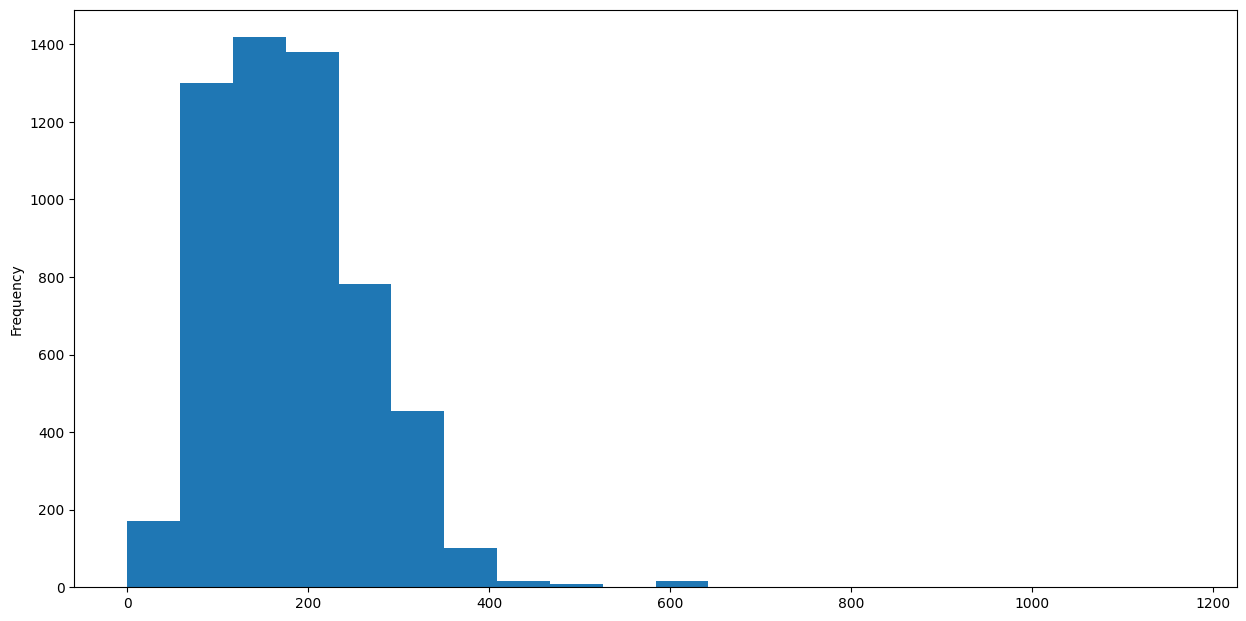

In [12]:
credits["CLAGE"].plot.hist(bins = 20,figsize=(15,7.5))
# # Most values are between 100 and 300 

<Axes: ylabel='Frequency'>

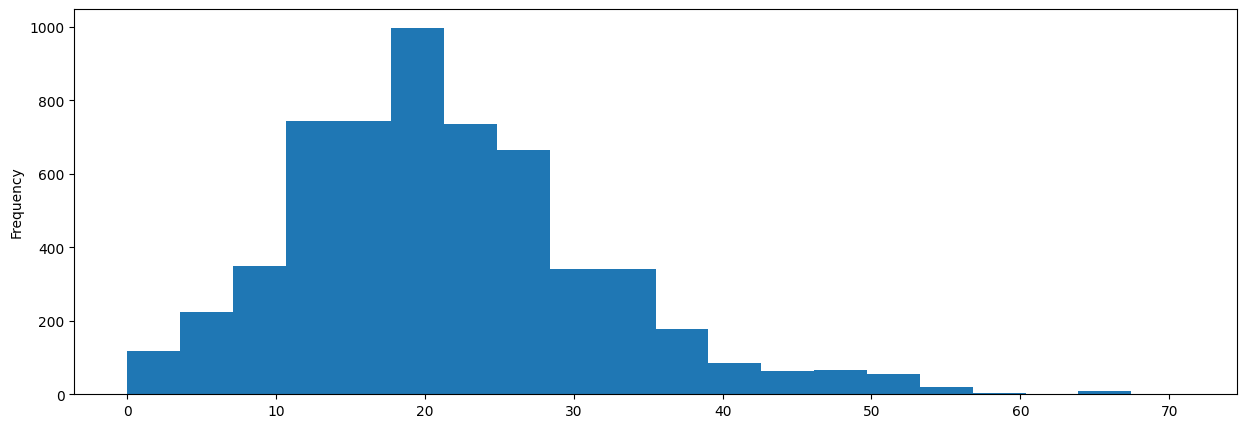

In [13]:
credits["CLNO"].plot.hist(bins = 20,figsize=(15,5))

<Axes: ylabel='Frequency'>

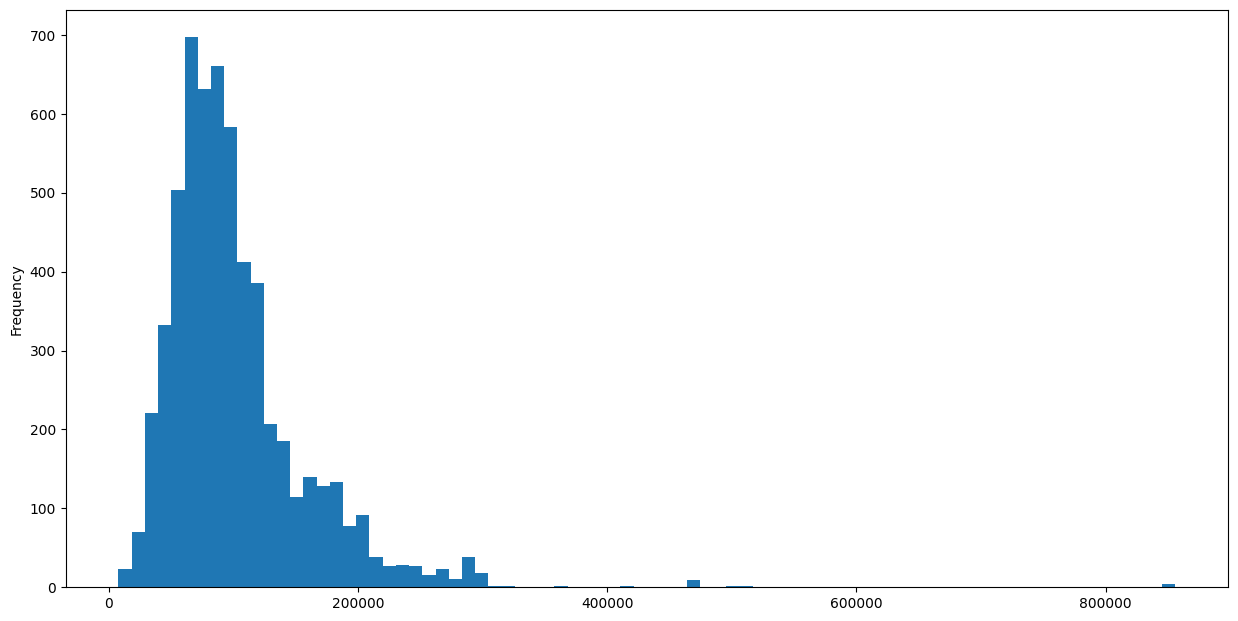

In [14]:
credits["VALUE"].plot.hist(bins = 80,figsize=(15,7.5))
# Most values are between 80 000 and 100 000

<Axes: ylabel='Frequency'>

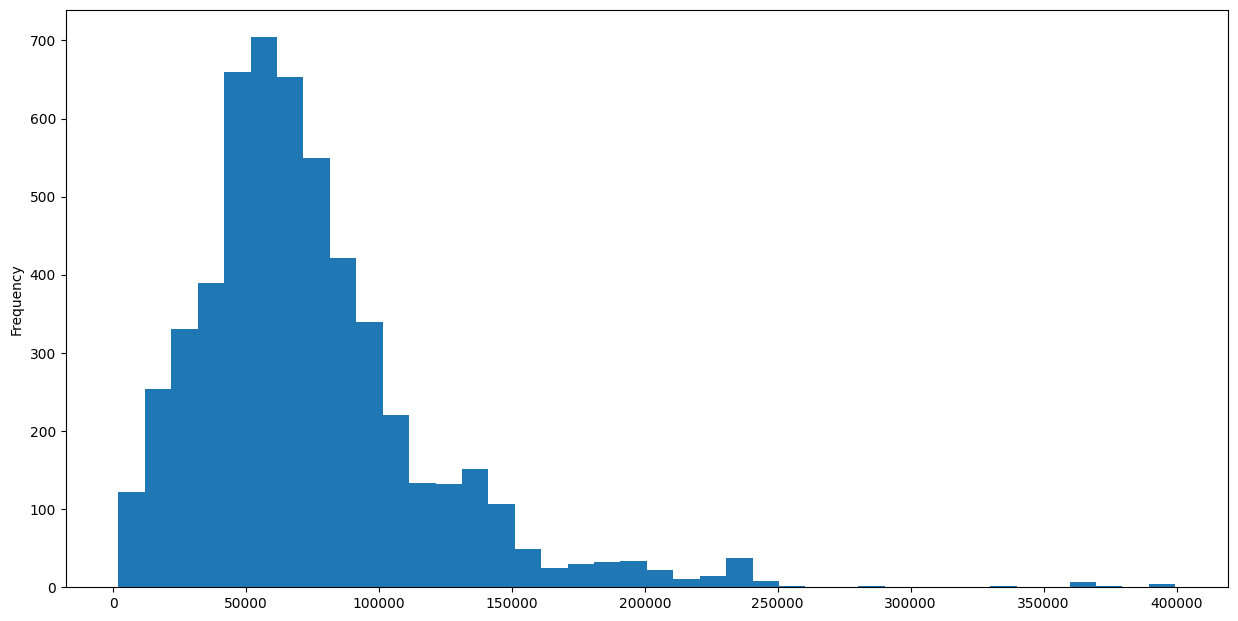

In [15]:
credits["MORTDUE"].plot.hist(bins = 40,figsize=(15,7.5))
# Most values are between 40 000 and 100 000

<Axes: ylabel='Frequency'>

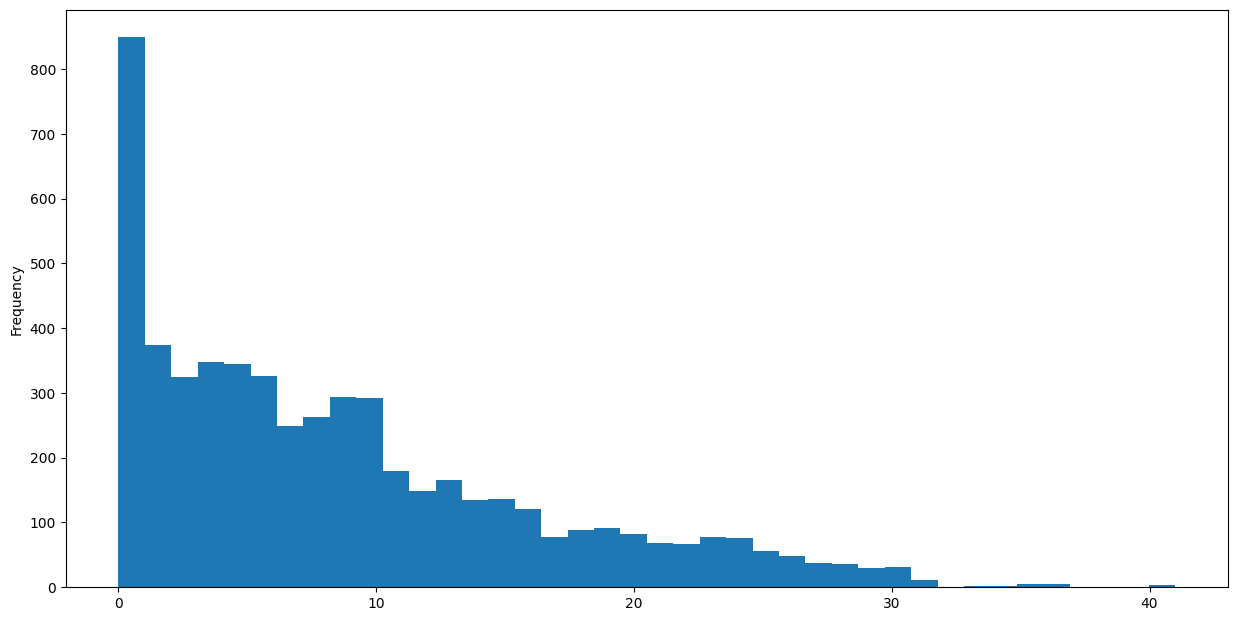

In [16]:
credits["YOJ"].plot.hist(bins = 40,figsize=(15,7.5))
# This is very skewed. It would be better if we modify this variable to decrease the skewness.

<Axes: >

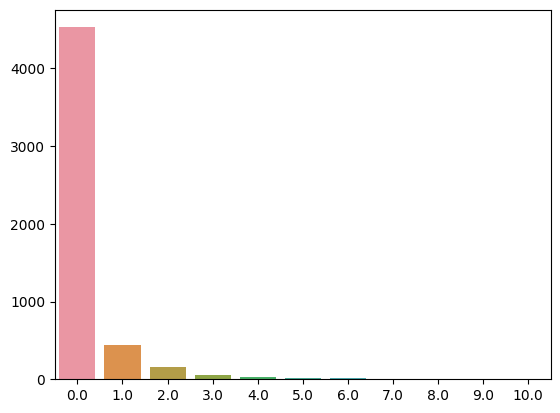

In [17]:
sns.barplot(data=credits, x=credits["DEROG"].value_counts().index, y=credits["DEROG"].value_counts().values)
# There are not many derogatory cases, so we may create a binary variable indicating whether an incident has occured or not instead of the number of incidents.

<Axes: >

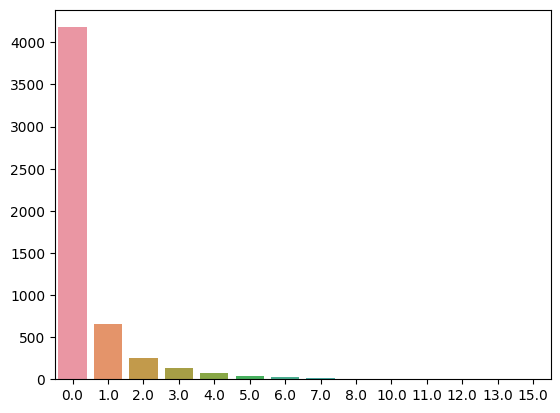

In [18]:
sns.barplot(data=credits, x=credits["DELINQ"].value_counts().index, y=credits["DELINQ"].value_counts().values)
# Most of them are zero. So acting as above could be a good idea.

<Axes: >

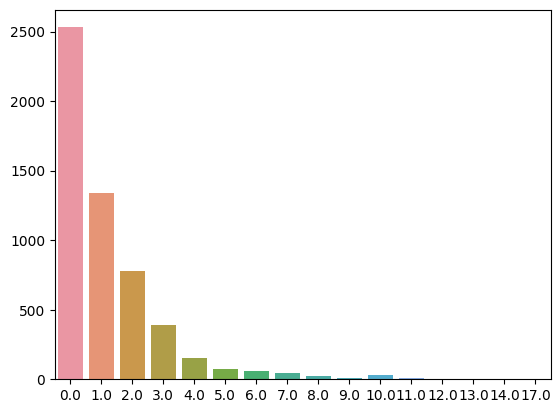

In [19]:
sns.barplot(data=credits, x=credits["NINQ"].value_counts().index, y=credits["NINQ"].value_counts().values)
# Distributed mostly among first five values

In conclusion, it can be stated that...

- The distributions exhibit no abnormalities, and the data is devoid of anomalies.

- The dataset of DEBTINC exhibits a remarkably elevated proportion of absent data which shall be addressed in a subsequent section, specifically through the imputation of the variables.

- The attribute YOJ exhibits a markedly asymmetrical distribution, and may warrant potential adjustment to ameliorate its skewness.

- The nominal features, namely JOB and REASON, require modification to render them suitable for the logistic regression model.

- To establish novel binary variables, the variables DELINQ and DEROG may be bifurcated into two categories.

- Thresholds may be imposed on the variables of VALUE, MORTDUE, CLAGE, and DEBTINC, whereby excessively high values will be limited to a designated lower value.

# Imputing the input variables
<br>

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64


<Axes: >

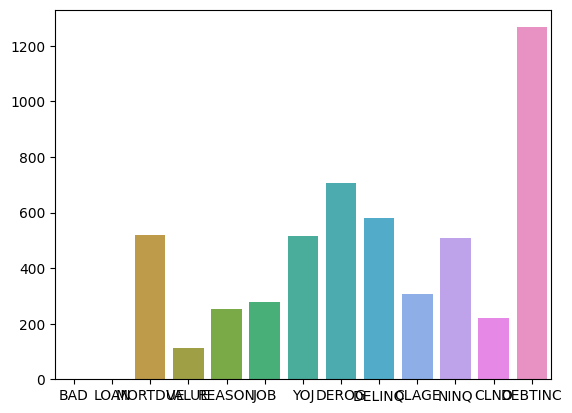

In [20]:
print(credits.isnull().sum())
sns.barplot(x=credits.isnull().sum().index, y=credits.isnull().sum().values)
# Number of cases with Nan.

With the exception of DEBTINC, a limited number of values were undisclosed in all other instances.

Several strategies may be considered for imputing missing values, including:
- Concerning nominal features, utilizing the majority class as a replacement is a viable approach.
- When considering numeric variables such as DEROG and DELINQ, the majority of instances often involve a value of 0. As such, the utilization of the majority class can be implemented as a replacement for these values.
- When presented with alternative numerical inputs, it is possible to substitute them with either the median or mean, with little to no alteration. Herein, the present study employs the mean value of the corresponding column to replace any such inputs.

# **Nominal features**

In [21]:
# Replacement using majority class: Other for JOB and DebtCon for REASON
credits["REASON"].fillna(value = "DebtCon",inplace = True)
credits["JOB"].fillna(value = "Other",inplace = True)
credits["DEROG"].fillna(value=0,inplace=True)
credits["DELINQ"].fillna(value=0,inplace=True)
# Replacement using mean of each class for numerical values in the numerical features.
credits.fillna(value=credits.mean(),inplace=True)
credits.isnull().sum()

<ipython-input-21-ae9d1d94b673>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  credits.fillna(value=credits.mean(),inplace=True)


BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# The implementation of models on the imputed data.

An application of the fundamental classification techniques on the data subsequent to replacement or imputation is warranted to evaluate its efficacy. To this end, an assessment of the performance of Logistic Regression, Decision Tree algorithms, LightGBM and CatBoost is necessary.

Prior to algorithm application, the data is partitioned into training and testing sets utilizing a 2:1 ratio, whereby 33% of the data is reserved for testing purposes and 67% allocated for training.

Furthermore, by excluding the JOB and REASON columns as input features, given their nominal characteristics, it is imperative to transform them into other variables for meaningful use. This transformational process is expounded upon in the subsequent section.

In [22]:
# import warnings
# warnings.filterwarnings('ignore')

In [23]:
y = credits["BAD"]
x = credits.drop(columns=["BAD","JOB","REASON"])
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =.33,random_state=1)

log_reg_1 = LogisticRegression()

# param_grid = [{'C': loguniform.rvs(1e-5, 1, size=10),
#                'max_iter': [100,500,1000],
#                'class_weight' : ['balanced'],
#                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#                'penalty': ['l1','l2']
#                }]

param_grid = [{'C': [0.002],
               'max_iter': [100],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l1']
               }]
grid_search = GridSearchCV(log_reg_1, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_1 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_log_reg_1.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_1.best_params_)

y_pred_log_1 = results_log_reg_1.predict(x_test)

accuracy_1 = accuracy_score(y_test,y_pred_log_1)
f1_1 = f1_score(y_test,y_pred_log_1, average="macro")
precision_1 = precision_score(y_test,y_pred_log_1, average="macro")
recall_1 = recall_score(y_test,y_pred_log_1, average="macro")

print("accuracy score : ",accuracy_1)
print("f1 score : ",f1_1)
print("precision score : ",precision_1)
print("recall score : ",recall_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6833006696064021
Best Hyperparameters: {'C': 0.002, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy score :  0.6822572445348246
f1 score :  0.6173734177116698
precision score :  0.619531414254678
recall score :  0.6722370717267887


In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1076  485]
 [ 140  266]]


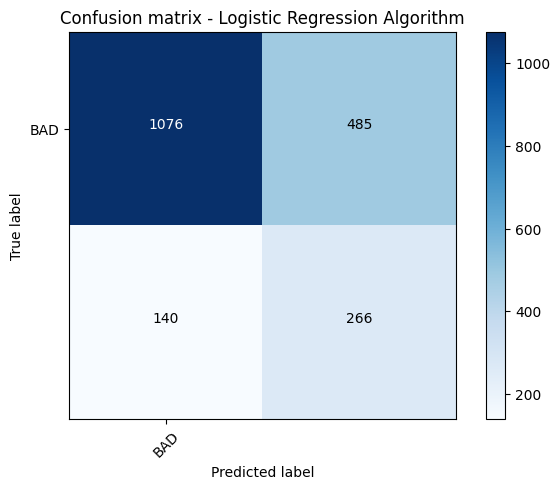

In [25]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_log_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7406663400293974
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.5}
accuracy score :  0.8357905439755974
f1 score :  0.7757170114711245
precision score :  0.7555591336106111
recall score :  0.8117972564006274
Confusion matrix, without normalization
[[1331  230]
 [  93  313]]


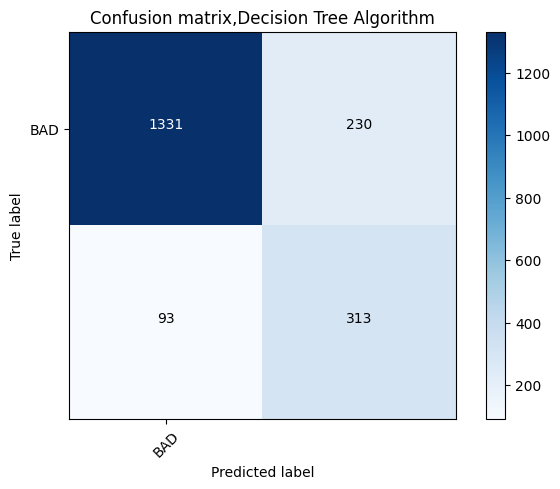

In [26]:
clf_tree_1 = DecisionTreeClassifier()

# param_grid = [{'class_weight':['balanced'], 
#                'criterion':['entropy','gini'], 
#                'max_depth':[10,50,100,500,1000],
#                'max_features':[0.3,0.5,9.8]
#                }]

param_grid = [{'class_weight':['balanced'], 
               'criterion':['entropy'], 
               'max_depth':[10],
               'max_features':[0.5]
               }]
            
grid_search = GridSearchCV(clf_tree_1, param_grid, cv=5, verbose=1, scoring='recall')

results_clf_tree_1 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_clf_tree_1.best_score_)
print('Best Hyperparameters: %s' % results_clf_tree_1.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_clf_tree_1 = results_clf_tree_1.predict(x_test)

accuracy_2 = accuracy_score(y_test,y_pred_clf_tree_1)
f1_2 = f1_score(y_test,y_pred_clf_tree_1, average="macro")
precision_2 = precision_score(y_test,y_pred_clf_tree_1, average="macro")
recall_2 = recall_score(y_test,y_pred_clf_tree_1, average="macro")

print("accuracy score : ",accuracy_2)
print("f1 score : ",f1_2)
print("precision score : ",precision_2)
print("recall score : ",recall_2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_clf_tree_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix,Decision Tree Algorithm')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6857422831945125
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 10, 'n_estimators': 2000}
accuracy score :  0.9176410777834265
f1 score :  0.8622977598008712
precision score :  0.9058525128987636
recall score :  0.832385296781462
Confusion matrix, without normalization
[[1526   35]
 [ 127  279]]


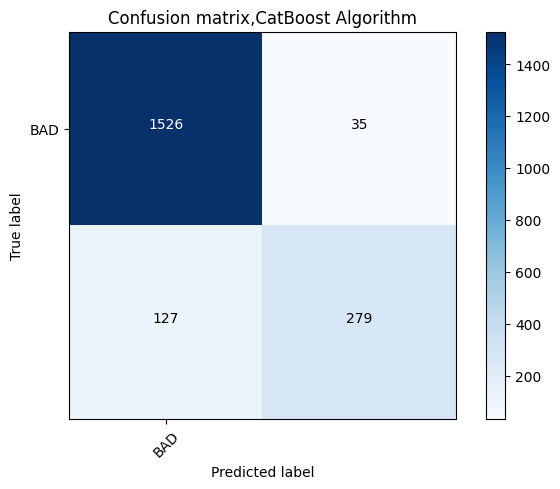

In [27]:
cat_boost_1 = catboost.CatBoostClassifier(verbose=False)

param_grid = [{
               'n_estimators':[2000], 
               'max_depth':[10],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_1, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_1 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_1.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_1.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_cat_boost_1 = results_cat_boost_1.predict(x_test)

accuracy_cat_boost_1 = accuracy_score(y_test,y_pred_cat_boost_1)
f1_cat_boost_1 = f1_score(y_test,y_pred_cat_boost_1, average="macro")
precision_cat_boost_1 = precision_score(y_test,y_pred_cat_boost_1, average="macro")
recall_cat_boost_1 = recall_score(y_test,y_pred_cat_boost_1, average="macro")

print("accuracy score : ",accuracy_cat_boost_1)
print("f1 score : ",f1_cat_boost_1)
print("precision score : ",precision_cat_boost_1)
print("recall score : ",recall_cat_boost_1)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_cat_boost_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix,CatBoost Algorithm')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6883227176220805
Best Hyperparameters: {'max_depth': 10, 'n_estimators': 2000}
accuracy score :  0.9161159125571937
f1 score :  0.8607949683657096
precision score :  0.8997238656537325
recall score :  0.8332468134926772
Confusion matrix, without normalization
[[1521   40]
 [ 125  281]]


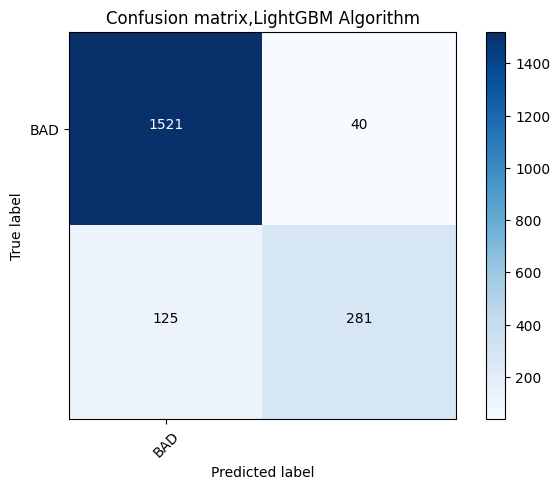

In [28]:
lightgbm_1 = lgb.LGBMClassifier(verbose=-1)

param_grid = [{
               'n_estimators':[2000], 
               'max_depth':[10]
               }]
            
grid_search = GridSearchCV(lightgbm_1, param_grid, cv=5, verbose=1, scoring='recall')

results_lightgbm_1 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_lightgbm_1.best_score_)
print('Best Hyperparameters: %s' % results_lightgbm_1.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_lightgbm_1 = results_lightgbm_1.predict(x_test)

accuracy_lightgbm_1 = accuracy_score(y_test,y_pred_lightgbm_1)
f1_lightgbm_1 = f1_score(y_test,y_pred_lightgbm_1, average="macro")
precision_lightgbm_1 = precision_score(y_test,y_pred_lightgbm_1, average="macro")
recall_lightgbm_1 = recall_score(y_test,y_pred_lightgbm_1, average="macro")

print("accuracy score : ",accuracy_lightgbm_1)
print("f1 score : ",f1_lightgbm_1)
print("precision score : ",precision_lightgbm_1)
print("recall score : ",recall_lightgbm_1)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_lightgbm_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix,LightGBM Algorithm')
plt.show()

- Here we need to diminish the number of false Negatives i.e, We anticipate that credit will be reimbursed but in reality being a fraudulant one.To diminish FN we should maximize Recall. Therefore, recall will the perfect evaluation metric for this model.

- Utilizing recall in spite of the fact that Precision is good, the model did not perform well on other performance metrics. Recall is fair over 67% and this is often not good. This may be due to overfitting and we are going attempt to evacuate this within the next segment.

- Surprisingly, Decision Tree calculation worked exceptionally well compared to logistic regression with a recall of almost 81% and exceptionally great accuracy. It demonstrates that performing variable selection by spliting the beat hubs based on the foremost important highlights of the information.

- The best models are LightGBM and CatBoost with a recall of 83%.

- There will be a great change in Logistic Regression model after Feature Selection.

# Feature transformation

In [29]:
credits.loc[credits["CLAGE"]>=600,"CLAGE"] = 600
credits.loc[credits["VALUE"]>=400000,"VALUE"] = 400000
credits.loc[credits["MORTDUE"]>=300000,"MORTDUE"] = 300000
credits.loc[credits["DEBTINC"]>=100,"DEBTINC"] = 100

In [30]:
credits["B_DEROG"] = (credits["DEROG"]>=1)*1
credits["B_DELINQ"] = (credits["DELINQ"]>=1)*1

In [31]:
credits["JOB"].unique()

array(['Other', 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'], dtype=object)

In [32]:
credits["REASON_1"] = (credits["REASON"] == "HomeImp")*1
credits["REASON_2"] = (credits["REASON"] != "HomeImp")*1
credits["JOB_1"] = (credits["JOB"]=="Other")*1
credits["JOB_2"] = (credits["JOB"]=="Office")*1
credits["JOB_3"] = (credits["JOB"]=="Sales")*1
credits["JOB_4"] = (credits["JOB"]=="Mgr")*1
credits["JOB_5"] = (credits["JOB"]=="ProfExe")*1
credits["JOB_6"] = (credits["JOB"]=="Self")*1
credits.drop(["JOB","REASON"],axis = 1,inplace = True)

In [33]:
# Decrease skewness YOJ applying log-transform.
credits["YOJ"] = credits["YOJ"].apply(lambda t : np.log(t+1))

In [34]:
credits.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


# Feature selection

- As we completed the transformation part, now we move on to Feature Selection.Now we will find out the most import features that are affecting the target variable "BAD" the most.
- We will use the following for this purpose :
    - Pearson correlation factor pearson
    - chi square test
    - f_regression
    - f_classif 

### Using Pearson Correlation factor for feature selection

In [35]:
credits.corr(method='pearson')

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
BAD,1.000000,-0.075099,-0.049420,-0.043711,-0.053066,0.269921,0.346503,-0.173412,0.168851,-0.004067,...,0.261216,0.308153,0.037517,-0.037517,0.037949,-0.073613,0.050934,0.032583,-0.043561,0.046245
LOAN,-0.075099,1.000000,0.214803,0.338749,0.102458,0.006996,-0.028869,0.088875,0.043160,0.071804,...,0.009079,-0.030646,-0.151477,0.151477,-0.058067,-0.018060,-0.044993,0.018769,0.017488,0.158452
MORTDUE,-0.049420,0.214803,1.000000,0.816001,-0.052771,-0.046526,0.002095,0.132928,0.026853,0.314779,...,-0.041471,-0.014568,-0.026941,0.026941,-0.259602,-0.066813,0.026023,0.076687,0.256575,0.107944
VALUE,-0.043711,0.338749,0.816001,1.000000,0.023878,-0.041263,-0.000578,0.178638,-0.004635,0.283654,...,-0.040482,-0.034988,-0.012308,0.012308,-0.288132,-0.058463,0.018250,0.051960,0.282653,0.163060
YOJ,-0.053066,0.102458,-0.052771,0.023878,1.000000,-0.050552,0.023185,0.145111,-0.052621,0.042928,...,-0.058295,0.023075,0.060306,-0.060306,0.023324,-0.066539,-0.041243,0.029926,0.024664,-0.010586
DEROG,0.269921,0.006996,-0.046526,-0.041263,-0.050552,1.000000,0.171286,-0.081231,0.146700,0.050727,...,0.755021,0.171622,-0.008406,0.008406,0.034537,-0.049223,0.030659,0.031342,-0.033939,0.000836
DELINQ,0.346503,-0.028869,0.002095,-0.000578,0.023185,0.171286,1.000000,0.026713,0.057212,0.159378,...,0.188767,0.748356,0.004024,-0.004024,-0.044718,0.005268,-0.016502,0.059350,-0.002911,0.021694
CLAGE,-0.173412,0.088875,0.132928,0.178638,0.145111,-0.081231,0.026713,1.000000,-0.110857,0.242213,...,-0.083332,0.007707,0.050670,-0.050670,-0.080490,0.000032,0.026502,-0.022948,0.112309,-0.010872
NINQ,0.168851,0.043160,0.026853,-0.004635,-0.052621,0.146700,0.057212,-0.110857,1.000000,0.085148,...,0.152237,0.059767,-0.115992,0.115992,0.054470,-0.063735,-0.035677,0.069826,-0.061553,0.016229
CLNO,-0.004067,0.071804,0.314779,0.283654,0.042928,0.050727,0.159378,0.242213,0.085148,1.000000,...,0.035880,0.154674,-0.107224,0.107224,-0.197815,-0.004549,0.049185,0.060210,0.165109,0.031325


In [36]:
# Gathering the 2 feature sets with high peason correlation value,one with 7 and other with 10 features in it

feat1=["DEROG","DELINQ","CLAGE","NINQ","DEBTINC","YOJ","LOAN"]
#feat2=["DEROG","DELINQ","CLAGE","NINQ","DEBTINC","LOAN","JOB_2","YOJ","JOB_3","MORTDUE"]

##### Now that we got the features with high correlation with the BAD feature, we will run the classification algorithms and compare them

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.687146823452556
Best Hyperparameters: {'C': 0.0004, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy score :  0.6842907981698018
f1 score :  0.6232039052077147
precision score :  0.6262642983212159
recall score :  0.6835417172899777
Confusion matrix, without normalization
[[1069  492]
 [ 129  277]]


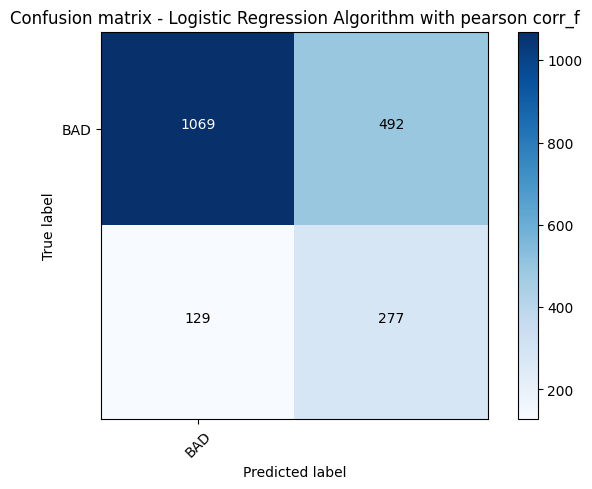

In [37]:
# Logistic Regression using above feature set 1

x = credits[feat1]
y = credits["BAD"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.33,random_state=1)

log_reg_2 = LogisticRegression()

# param_grid = [{'C': loguniform.rvs(1e-5, 1, size=10),
#                'max_iter': [100,500,1000],
#                'class_weight' : ['balanced'],
#                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#                'penalty': ['l1','l2']
#                }]

param_grid = [{'C': [0.0004],
               'max_iter': [100],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l2']
               }]
            
grid_search = GridSearchCV(log_reg_2, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_2 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_log_reg_2.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_2.best_params_)

y_pred_log_2 = results_log_reg_2.predict(x_test)

accuracy_3 = accuracy_score(y_test,y_pred_log_2)
f1_3 = f1_score(y_test,y_pred_log_2, average="macro")
precision_3 = precision_score(y_test,y_pred_log_2, average="macro")
recall_3 = recall_score(y_test,y_pred_log_2, average="macro")

print("accuracy score : ",accuracy_3)
print("f1 score : ",f1_3)
print("precision score : ",precision_3)
print("recall score : ",recall_3)

# Plot Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_log_2)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm with pearson corr_f')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7394659480646741
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.5}
accuracy score :  0.8520589730554143
f1 score :  0.7888856801114442
precision score :  0.7735158673845597
recall score :  0.810201241467671
Confusion matrix, without normalization
[[1376  185]
 [ 106  300]]


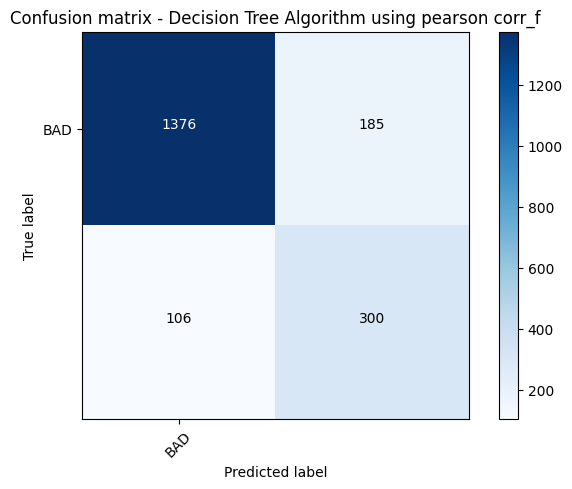

In [38]:
# Decision Tree classifier using feat1
clf_tree_2=DecisionTreeClassifier()

# param_grid = [{'class_weight':['balanced'], 
#                'criterion':['entropy','gini'], 
#                'max_depth':[10,50,100,500,1000],
#                'max_features':[0.3,0.5,9.8]
#                }]

param_grid = [{'class_weight':['balanced'], 
               'criterion':['gini'], 
               'max_depth':[10],
               'max_features':[0.5]
               }]
            
grid_search = GridSearchCV(clf_tree_2, param_grid, cv=5, verbose=1, scoring='recall')

results_clf_tree_2 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_clf_tree_2.best_score_)
print('Best Hyperparameters: %s' % results_clf_tree_2.best_params_)

y_pred_clf_tree_2 = results_clf_tree_2.predict(x_test)

accuracy_4 = accuracy_score(y_test,y_pred_clf_tree_2)
f1_4 = f1_score(y_test,y_pred_clf_tree_2, average="macro")
precision_4 = precision_score(y_test,y_pred_clf_tree_2, average="macro")
recall_4 = recall_score(y_test,y_pred_clf_tree_2, average="macro")

print("accuracy score : ",accuracy_4)
print("f1 score : ",f1_4)
print("precision score : ",precision_4)
print("recall score : ",recall_4)
# Computing Confusion matrix for the above algorithm
cnf_matrix = confusion_matrix(y_test, y_pred_clf_tree_2)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Decision Tree Algorithm using pearson corr_f')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6525314388371714
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 10, 'n_estimators': 1000}
accuracy score :  0.9018810371123538
f1 score :  0.8350567109187799
precision score :  0.8786027146989588
recall score :  0.8060538116591929
Confusion matrix, without normalization
[[1513   48]
 [ 145  261]]


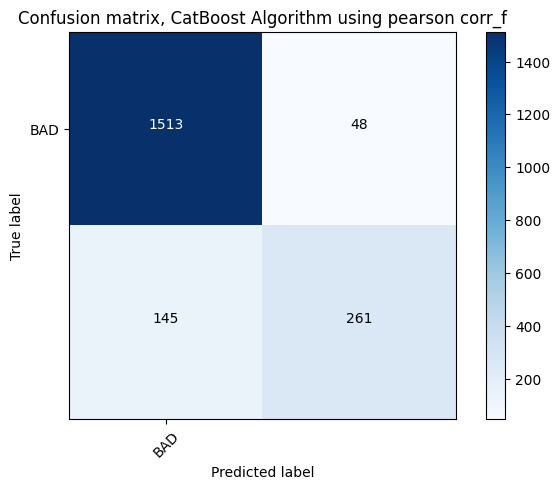

In [39]:
cat_boost_2 = catboost.CatBoostClassifier(verbose=False)

param_grid = [{
               'n_estimators':[1000], 
               'max_depth':[10],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_2, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_2 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_2.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_2.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_cat_boost_2 = results_cat_boost_2.predict(x_test)

accuracy_cat_boost_2 = accuracy_score(y_test,y_pred_cat_boost_2)
f1_cat_boost_2 = f1_score(y_test,y_pred_cat_boost_2, average="macro")
precision_cat_boost_2 = precision_score(y_test,y_pred_cat_boost_2, average="macro")
recall_cat_boost_2 = recall_score(y_test,y_pred_cat_boost_2, average="macro")

print("accuracy score : ",accuracy_cat_boost_2)
print("f1 score : ",f1_cat_boost_2)
print("precision score : ",precision_cat_boost_2)
print("recall score : ",recall_cat_boost_2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_cat_boost_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix, CatBoost Algorithm using pearson corr_f')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6512167238281888
Best Hyperparameters: {'max_depth': 4, 'n_estimators': 500}
accuracy score :  0.8896797153024911
f1 score :  0.814947959952987
precision score :  0.8548278111747984
recall score :  0.7883430161920961
Confusion matrix, without normalization
[[1500   61]
 [ 156  250]]


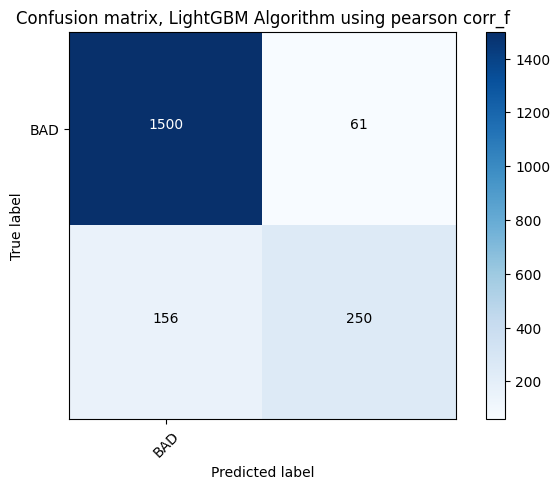

In [40]:
lightgbm_2 = lgb.LGBMClassifier(verbose=-1)

param_grid = [{
               'n_estimators':[500], 
               'max_depth':[4]
               }]
            
grid_search = GridSearchCV(lightgbm_2, param_grid, cv=5, verbose=1, scoring='recall')

results_lightgbm_2 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_lightgbm_2.best_score_)
print('Best Hyperparameters: %s' % results_lightgbm_2.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_lightgbm_2 = results_lightgbm_2.predict(x_test)

accuracy_lightgbm_2 = accuracy_score(y_test,y_pred_lightgbm_2)
f1_lightgbm_2 = f1_score(y_test,y_pred_lightgbm_2, average="macro")
precision_lightgbm_2 = precision_score(y_test,y_pred_lightgbm_2, average="macro")
recall_lightgbm_2 = recall_score(y_test,y_pred_lightgbm_2, average="macro")

print("accuracy score : ",accuracy_lightgbm_2)
print("f1 score : ",f1_lightgbm_2)
print("precision score : ",precision_lightgbm_2)
print("recall score : ",recall_lightgbm_2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_lightgbm_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix, LightGBM Algorithm using pearson corr_f')
plt.show()

### Using chi2 test for feature selection

In [41]:
# Finding the best 10 features using chi2 test
df_new = pd.DataFrame(SelectKBest(chi2, k=10).fit_transform(credits.drop(["BAD"],axis = 1),credits["BAD"]))

In [42]:
# dataframe containing the selected features
df_new.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,25860.0000,39025.000000,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0
1,1300.0,70053.0000,68400.000000,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0
2,1500.0,13500.0000,16700.000000,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0
3,1500.0,73760.8172,101776.048741,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0
4,1700.0,97800.0000,112000.000000,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7011840601012576
Best Hyperparameters: {'C': 0.0003, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy score :  0.6832740213523132
f1 score :  0.6201225400161505
precision score :  0.6226468907328395
recall score :  0.6774337847091829
Confusion matrix, without normalization
[[1073  488]
 [ 135  271]]


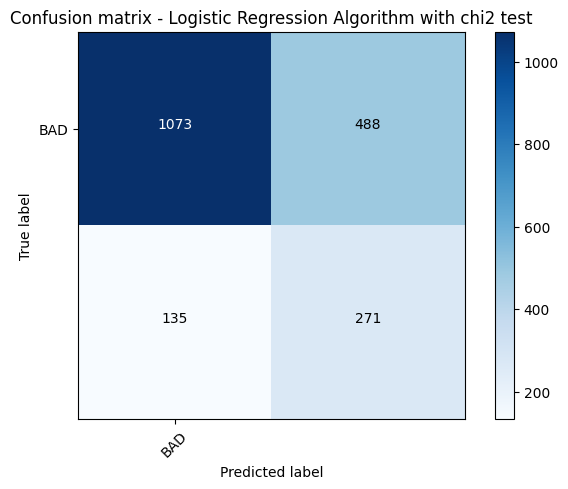

In [43]:
# Running the logistic regression algorithm using the features selected from chi2 test

x = df_new
y = credits["BAD"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .33,random_state=1)

log_reg_3 = LogisticRegression()

# param_grid = [{'C': loguniform.rvs(1e-5, 1, size=10),
#                'max_iter': [100,500,1000],
#                'class_weight' : ['balanced'],
#                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#                'penalty': ['l1','l2']
#                }]

param_grid = [{'C': [0.0003],
               'max_iter': [100],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l2']
               }]
            
grid_search = GridSearchCV(log_reg_3, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_3 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_log_reg_3.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_3.best_params_)

y_pred_log_3 = results_log_reg_3.predict(x_test)

accuracy_5 = accuracy_score(y_test,y_pred_log_3)
f1_5 = f1_score(y_test,y_pred_log_3, average="macro")
precision_5 = precision_score(y_test,y_pred_log_3, average="macro")
recall_5 = recall_score(y_test,y_pred_log_3, average="macro")

print("accuracy score : ",accuracy_5)
print("f1 score : ",f1_5)
print("precision score : ",precision_5)
print("recall score : ",recall_5)

# Computing Confusion matrix for the above algorithm
cnf_matrix = confusion_matrix(y_test, y_pred_log_3)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm with chi2 test')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7304915890903152
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.5}
accuracy score :  0.8678190137264871
f1 score :  0.8062221696812074
precision score :  0.7954386810362453
recall score :  0.8192195542203273
Confusion matrix, without normalization
[[1408  153]
 [ 107  299]]


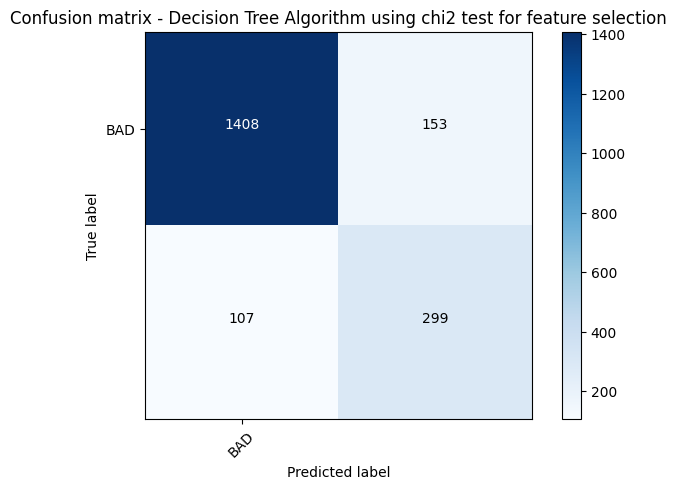

In [44]:
# Decision Tree classifier using features from chi2 test

clf_tree_3=DecisionTreeClassifier()

param_grid = [{'class_weight':['balanced'], 
               'criterion':['entropy'], 
               'max_depth':[10],
               'max_features':[0.5]
               }]
            
grid_search = GridSearchCV(clf_tree_3, param_grid, cv=5, verbose=1, scoring='recall')

results_clf_tree_3 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_clf_tree_3.best_score_)
print('Best Hyperparameters: %s' % results_clf_tree_3.best_params_)

y_pred_clf_tree_3 = results_clf_tree_3.predict(x_test)

accuracy_6 = accuracy_score(y_test,y_pred_clf_tree_3)
f1_6 = f1_score(y_test,y_pred_clf_tree_3, average="macro")
precision_6 = precision_score(y_test,y_pred_clf_tree_3, average="macro")
recall_6 = recall_score(y_test,y_pred_clf_tree_3, average="macro")

print("accuracy score : ",accuracy_6)
print("f1 score : ",f1_6)
print("precision score : ",precision_6)
print("recall score : ",recall_6)

cnf_matrix = confusion_matrix(y_test, y_pred_clf_tree_3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Decision Tree Algorithm using chi2 test for feature selection')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6525151069737056
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 10, 'n_estimators': 2000}
accuracy score :  0.9089984748347738
f1 score :  0.8483372983515776
precision score :  0.8884160214128669
recall score :  0.8205615321743356
Confusion matrix, without normalization
[[1516   45]
 [ 134  272]]


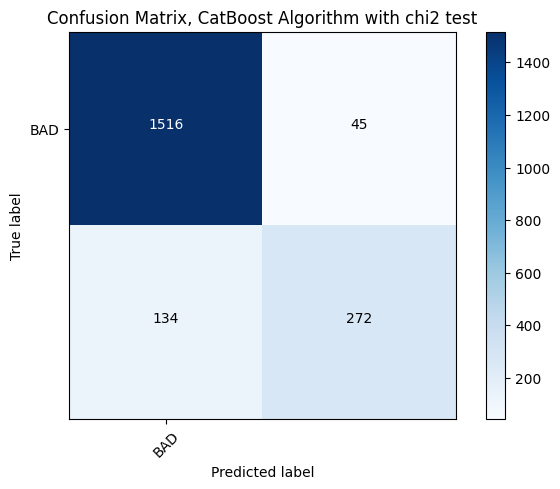

In [45]:
cat_boost_3 = catboost.CatBoostClassifier(verbose=False)

param_grid = [{
               'n_estimators':[2000], 
               'max_depth':[10],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_3, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_3 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_3.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_3.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_cat_boost_3 = results_cat_boost_3.predict(x_test)

accuracy_cat_boost_3 = accuracy_score(y_test,y_pred_cat_boost_3)
f1_cat_boost_3 = f1_score(y_test,y_pred_cat_boost_3, average="macro")
precision_cat_boost_3 = precision_score(y_test,y_pred_cat_boost_3, average="macro")
recall_cat_boost_3 = recall_score(y_test,y_pred_cat_boost_3, average="macro")

print("accuracy score : ",accuracy_cat_boost_3)
print("f1 score : ",f1_cat_boost_3)
print("precision score : ",precision_cat_boost_3)
print("recall score : ",recall_cat_boost_3)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_cat_boost_3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion Matrix, CatBoost Algorithm with chi2 test')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6589008655887636
Best Hyperparameters: {'max_depth': 16, 'n_estimators': 1000}
accuracy score :  0.8993390950686324
f1 score :  0.8324185470129601
precision score :  0.8701624006926248
recall score :  0.8062747133800172
Confusion matrix, without normalization
[[1506   55]
 [ 143  263]]


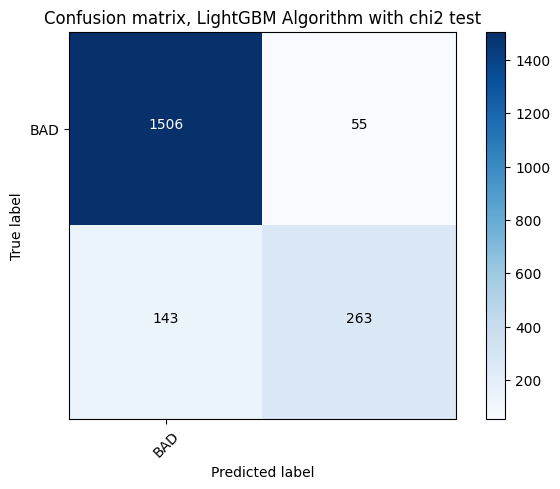

In [46]:
lightgbm_3 = lgb.LGBMClassifier(verbose=-1)

param_grid = [{
               'n_estimators':[1000], 
               'max_depth':[16]
               }]
            
grid_search = GridSearchCV(lightgbm_3, param_grid, cv=5, verbose=1, scoring='recall')

results_lightgbm_3 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_lightgbm_3.best_score_)
print('Best Hyperparameters: %s' % results_lightgbm_3.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_lightgbm_3 = results_lightgbm_3.predict(x_test)

accuracy_lightgbm_3 = accuracy_score(y_test,y_pred_lightgbm_3)
f1_lightgbm_3 = f1_score(y_test,y_pred_lightgbm_3, average="macro")
precision_lightgbm_3 = precision_score(y_test,y_pred_lightgbm_3, average="macro")
recall_lightgbm_3 = recall_score(y_test,y_pred_lightgbm_3, average="macro")

print("accuracy score : ",accuracy_lightgbm_3)
print("f1 score : ",f1_lightgbm_3)
print("precision score : ",precision_lightgbm_3)
print("recall score : ",recall_lightgbm_3)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_lightgbm_3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix, LightGBM Algorithm with chi2 test')
plt.show()

In [47]:
credits.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


### Using f_classif for feature selection

In [48]:
df_new2 = pd.DataFrame(SelectKBest(f_classif, k=10).fit_transform(credits.drop(["BAD"],axis=1),credits["BAD"]))
df_new2.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6960640209047851
Best Hyperparameters: {'C': 0.0005, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy score :  0.6959837315709202
f1 score :  0.6318471584777443
precision score :  0.6313454040837904
recall score :  0.6881751308842696
Confusion matrix, without normalization
[[1095  466]
 [ 132  274]]


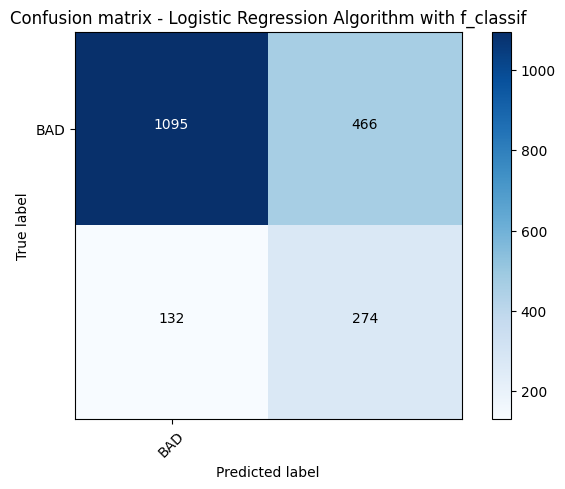

In [49]:
# Running the logistic regression algorithm using the features selected from f_classif test
x = df_new2
y = credits["BAD"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .33,random_state=1)

log_reg_4 = LogisticRegression()

param_grid = [{'C': [0.0005],
               'max_iter': [100],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l2']
               }]
            
grid_search = GridSearchCV(log_reg_4, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_4 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_log_reg_4.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_4.best_params_)

y_pred_log_4 = results_log_reg_4.predict(x_test)

accuracy_7 = accuracy_score(y_test,y_pred_log_4)
f1_7 = f1_score(y_test,y_pred_log_4, average="macro")
precision_7 = precision_score(y_test,y_pred_log_4, average="macro")
recall_7 = recall_score(y_test,y_pred_log_4, average="macro")

print("accuracy score : ",accuracy_7)
print("f1 score : ",f1_7)
print("precision score : ",precision_7)
print("recall score : ",recall_7)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_log_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm with f_classif')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7203413359464316
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.5}
accuracy score :  0.8190137264870361
f1 score :  0.7600614569855924
precision score :  0.7394700877091092
recall score :  0.805783207051183
Confusion matrix, without normalization
[[1293  268]
 [  88  318]]


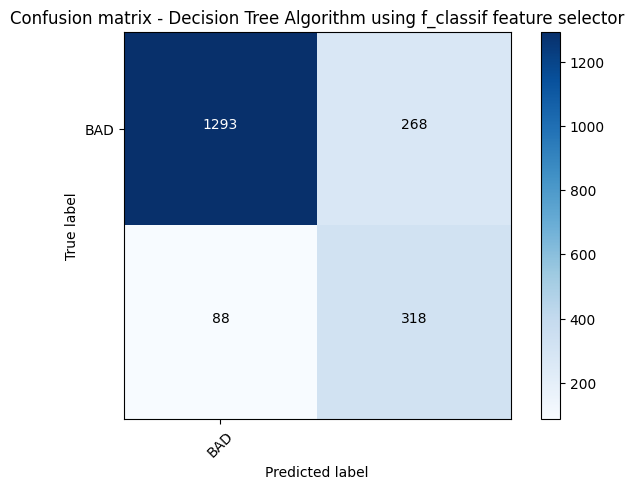

In [50]:
# Decision Tree classifier using features from f_classif test
clf_tree_4=DecisionTreeClassifier()

param_grid = [{'class_weight':['balanced'], 
               'criterion':['entropy'], 
               'max_depth':[10],
               'max_features':[0.5]
               }]
            
grid_search = GridSearchCV(clf_tree_4, param_grid, cv=5, verbose=1, scoring='recall')

results_clf_tree_4 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_clf_tree_4.best_score_)
print('Best Hyperparameters: %s' % results_clf_tree_4.best_params_)

y_pred_clf_tree_4 = results_clf_tree_4.predict(x_test)

accuracy_8 = accuracy_score(y_test,y_pred_clf_tree_4)
f1_8 = f1_score(y_test,y_pred_clf_tree_4, average="macro")
precision_8 = precision_score(y_test,y_pred_clf_tree_4, average="macro")
recall_8 = recall_score(y_test,y_pred_clf_tree_4, average="macro")

print("accuracy score : ",accuracy_8)
print("f1 score : ",f1_8)
print("precision score : ",precision_8)
print("recall score : ",recall_8)
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_clf_tree_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Decision Tree Algorithm using f_classif feature selector')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6512738853503184
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 30, 'n_estimators': 1000}
accuracy score :  0.9054397559735639
f1 score :  0.8408659115820241
precision score :  0.8857745629897529
recall score :  0.8110296229207625
Confusion matrix, without normalization
[[1517   44]
 [ 142  264]]


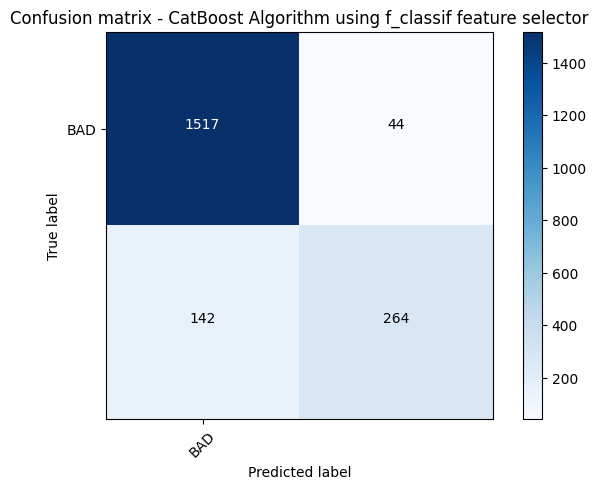

In [51]:
cat_boost_4 = catboost.CatBoostClassifier(verbose=False)

param_grid = [{
               'n_estimators':[1000], 
               'max_depth':[30],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_4, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_4 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_4.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_4.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_cat_boost_4 = results_cat_boost_4.predict(x_test)

accuracy_cat_boost_4 = accuracy_score(y_test,y_pred_cat_boost_4)
f1_cat_boost_4 = f1_score(y_test,y_pred_cat_boost_4, average="macro")
precision_cat_boost_4 = precision_score(y_test,y_pred_cat_boost_4, average="macro")
recall_cat_boost_4 = recall_score(y_test,y_pred_cat_boost_4, average="macro")

print("accuracy score : ",accuracy_cat_boost_4)
print("f1 score : ",f1_cat_boost_4)
print("precision score : ",precision_cat_boost_4)
print("recall score : ",recall_cat_boost_4)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_cat_boost_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - CatBoost Algorithm using f_classif feature selector')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6601910828025478
Best Hyperparameters: {'max_depth': 16, 'n_estimators': 500}
accuracy score :  0.9008642602948653
f1 score :  0.832983754489842
precision score :  0.8775469958007928
recall score :  0.8035907574720007
Confusion matrix, without normalization
[[1513   48]
 [ 147  259]]


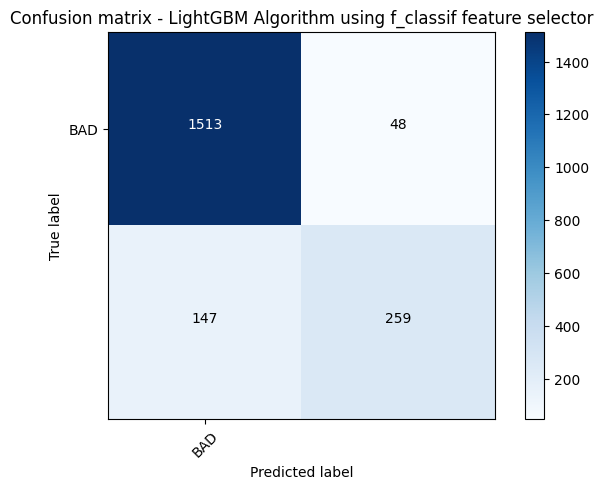

In [52]:
lightgbm_4 = lgb.LGBMClassifier(verbose=-1)

param_grid = [{
               'n_estimators':[500], 
               'max_depth':[16]
               }]
            
grid_search = GridSearchCV(lightgbm_4, param_grid, cv=5, verbose=1, scoring='recall')

results_lightgbm_4 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_lightgbm_4.best_score_)
print('Best Hyperparameters: %s' % results_lightgbm_4.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_lightgbm_4 = results_lightgbm_4.predict(x_test)

accuracy_lightgbm_4 = accuracy_score(y_test,y_pred_lightgbm_4)
f1_lightgbm_4 = f1_score(y_test,y_pred_lightgbm_4, average="macro")
precision_lightgbm_4 = precision_score(y_test,y_pred_lightgbm_4, average="macro")
recall_lightgbm_4 = recall_score(y_test,y_pred_lightgbm_4, average="macro")

print("accuracy score : ",accuracy_lightgbm_4)
print("f1 score : ",f1_lightgbm_4)
print("precision score : ",precision_lightgbm_4)
print("recall score : ",recall_lightgbm_4)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_lightgbm_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - LightGBM Algorithm using f_classif feature selector')
plt.show()

### Using f_regression for feature selection

In [53]:
df_new3 = pd.DataFrame(SelectKBest(f_regression, k=10).fit_transform(credits.drop(["BAD"],axis=1),credits["BAD"]))
df_new3.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6896700963579944
Best Hyperparameters: {'C': 0.0007, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy score :  0.7076766649720386
f1 score :  0.6436069831320488
precision score :  0.6406747792518969
recall score :  0.7000983012657669
Confusion matrix, without normalization
[[1113  448]
 [ 127  279]]


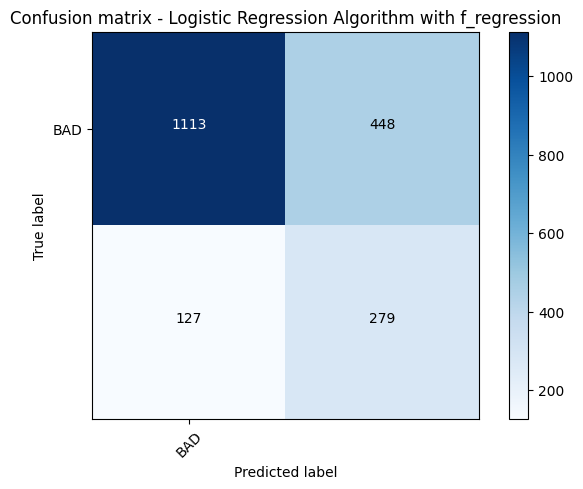

In [54]:
# Running the logistic regression algorithm using the features selected from f_regression test

x = df_new3
y = credits["BAD"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .33,random_state=1)

logreg_5 = LogisticRegression()

param_grid = [{'C': [0.0007],
               'max_iter': [100],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l2']
               }]
            
grid_search = GridSearchCV(logreg_5, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_5 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_log_reg_5.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_5.best_params_)

y_pred_log_5 = results_log_reg_5.predict(x_test)

accuracy_9 = accuracy_score(y_test,y_pred_log_5)
f1_9 = f1_score(y_test,y_pred_log_5, average="macro")
precision_9 = precision_score(y_test,y_pred_log_5, average="macro")
recall_9 = recall_score(y_test,y_pred_log_5, average="macro")

print("accuracy score : ",accuracy_9)
print("f1 score : ",f1_9)
print("precision score : ",precision_9)
print("recall score : ",recall_9)
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_log_5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm with f_regression')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.7356279601502532
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.3}
accuracy score :  0.8068124046771734
f1 score :  0.7381963124859897
precision score :  0.7206854351419644
recall score :  0.7725816784112749
Confusion matrix, without normalization
[[1297  264]
 [ 116  290]]


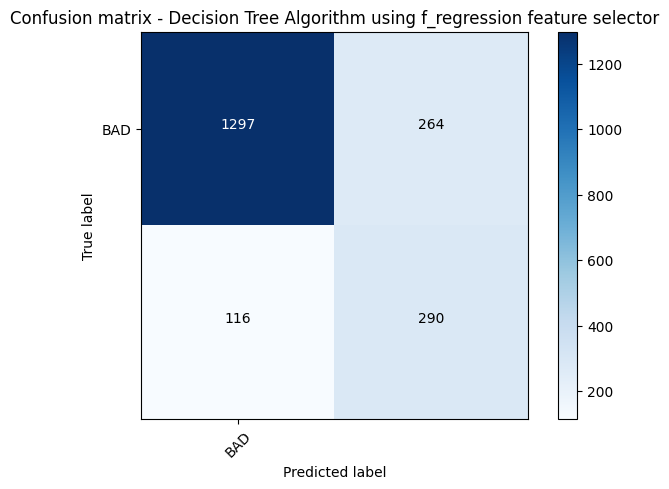

In [55]:
# Decision Tree classifier using features from f_regression test
clf_tree_5=DecisionTreeClassifier()

param_grid = [{'class_weight':['balanced'], 
               'criterion':['entropy'], 
               'max_depth':[10],
               'max_features':[0.3]
               }]
            
grid_search = GridSearchCV(clf_tree_5, param_grid, cv=5, verbose=1, scoring='recall')

results_clf_tree_5 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_clf_tree_5.best_score_)
print('Best Hyperparameters: %s' % results_clf_tree_5.best_params_)

y_pred_clf_tree_5 = results_clf_tree_5.predict(x_test)

accuracy_10 = accuracy_score(y_test,y_pred_clf_tree_5)
f1_10 = f1_score(y_test,y_pred_clf_tree_5, average="macro")
precision_10 = precision_score(y_test,y_pred_clf_tree_5, average="macro")
recall_10 = recall_score(y_test,y_pred_clf_tree_5, average="macro")

print("accuracy score : ",accuracy_10)
print("f1 score : ",f1_10)
print("precision score : ",precision_10)
print("recall score : ",recall_10)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_clf_tree_5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Decision Tree Algorithm using f_regression feature selector')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6512738853503184
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 30, 'n_estimators': 1000}
accuracy score :  0.9054397559735639
f1 score :  0.8408659115820241
precision score :  0.8857745629897529
recall score :  0.8110296229207625
Confusion matrix, without normalization
[[1517   44]
 [ 142  264]]


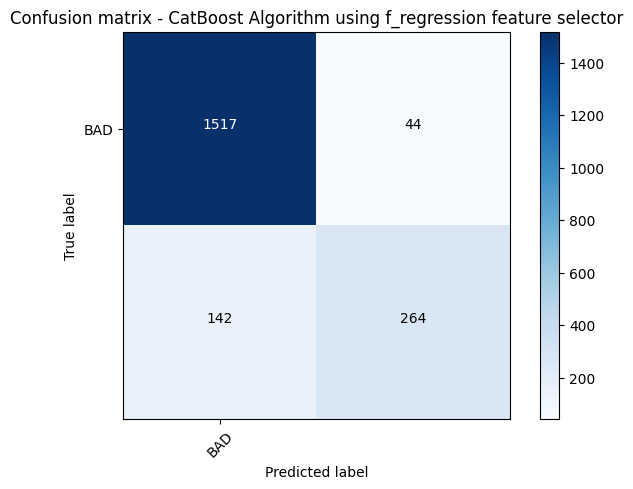

In [56]:
cat_boost_5 = catboost.CatBoostClassifier(verbose=False)

param_grid = [{
               'n_estimators':[1000], 
               'max_depth':[30],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_5, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_5 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_5.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_5.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_cat_boost_5 = results_cat_boost_4.predict(x_test)

accuracy_cat_boost_5 = accuracy_score(y_test,y_pred_cat_boost_5)
f1_cat_boost_5 = f1_score(y_test,y_pred_cat_boost_5, average="macro")
precision_cat_boost_5 = precision_score(y_test,y_pred_cat_boost_5, average="macro")
recall_cat_boost_5 = recall_score(y_test,y_pred_cat_boost_5, average="macro")

print("accuracy score : ",accuracy_cat_boost_5)
print("f1 score : ",f1_cat_boost_5)
print("precision score : ",precision_cat_boost_5)
print("recall score : ",recall_cat_boost_5)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_cat_boost_5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - CatBoost Algorithm using f_regression feature selector')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6601910828025478
Best Hyperparameters: {'max_depth': 16, 'n_estimators': 500}
accuracy score :  0.9008642602948653
f1 score :  0.832983754489842
precision score :  0.8775469958007928
recall score :  0.8035907574720007
Confusion matrix, without normalization
[[1513   48]
 [ 147  259]]


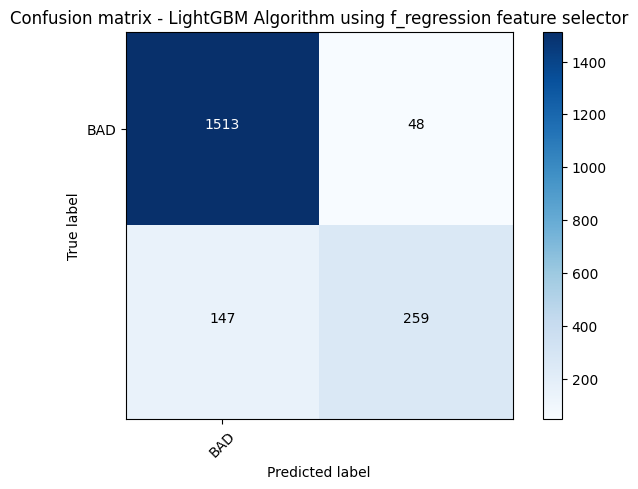

In [57]:
lightgbm_5 = lgb.LGBMClassifier(verbose=-1)

param_grid = [{
               'n_estimators':[500], 
               'max_depth':[16]
               }]
            
grid_search = GridSearchCV(lightgbm_5, param_grid, cv=5, verbose=1, scoring='recall')

results_lightgbm_5 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_lightgbm_5.best_score_)
print('Best Hyperparameters: %s' % results_lightgbm_5.best_params_)

# Predicting the output of the test cases using the algorithm created above
y_pred_lightgbm_5 = results_lightgbm_5.predict(x_test)

accuracy_lightgbm_5 = accuracy_score(y_test,y_pred_lightgbm_5)
f1_lightgbm_5 = f1_score(y_test,y_pred_lightgbm_5, average="macro")
precision_lightgbm_5 = precision_score(y_test,y_pred_lightgbm_5, average="macro")
recall_lightgbm_5 = recall_score(y_test,y_pred_lightgbm_5, average="macro")

print("accuracy score : ",accuracy_lightgbm_5)
print("f1 score : ",f1_lightgbm_5)
print("precision score : ",precision_lightgbm_5)
print("recall score : ",recall_lightgbm_5)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_pred_lightgbm_5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - LightGBM Algorithm using f_regression feature selector')
plt.show()

# Comparing all the models
 - We can now rank our evaluation of all the models to choose the best one for our problem. 

In [58]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','CatBoost','LightGBM',
              'Logistic Regression', 'Decision Tree','CatBoost','LightGBM',
              'Logistic Regression', 'Decision Tree','CatBoost','LightGBM',
              'Logistic Regression', 'Decision Tree','CatBoost','LightGBM',
              'Logistic Regression', 'Decision Tree','CatBoost','LightGBM'],
    'Feature Selection Method' : ['None','None','None','None',
                                  'Pearson corr_fact','Pearson corr_fact','Pearson corr_fact','Pearson corr_fact',
                                  'chi2 test','chi2 test','chi2 test','chi2 test',
                                  'f_classif','f_classif','f_classif','f_classif',
                                  'f_regression','f_regression','f_regression','f_regression'],
    'Accuracy Score': [accuracy_1,accuracy_2,accuracy_cat_boost_1,accuracy_lightgbm_1,
                       accuracy_3,accuracy_4,accuracy_cat_boost_2,accuracy_lightgbm_2,
                       accuracy_5,accuracy_6,accuracy_cat_boost_3,accuracy_lightgbm_3,
                       accuracy_7,accuracy_8,accuracy_cat_boost_4,accuracy_lightgbm_4,
                       accuracy_9,accuracy_10,accuracy_cat_boost_5,accuracy_lightgbm_5],
    'Recall Score' : [recall_1,recall_2,recall_cat_boost_1,recall_lightgbm_1,
                      recall_3,recall_4,recall_cat_boost_2,recall_lightgbm_2,
                      recall_5,recall_6,recall_cat_boost_3,recall_lightgbm_3,
                      recall_7,recall_8,recall_cat_boost_4,recall_lightgbm_4,
                      recall_9,recall_10,recall_cat_boost_5,recall_lightgbm_5],
    'F1 Score' : [f1_1,f1_2,f1_cat_boost_1,f1_lightgbm_1,
                  f1_3,f1_4,f1_cat_boost_2,f1_lightgbm_2,
                  f1_5,f1_6,f1_cat_boost_3,f1_lightgbm_3,
                  f1_7,f1_8,f1_cat_boost_4,f1_lightgbm_4,
                  f1_9,f1_10,f1_cat_boost_5,f1_lightgbm_5],
    'Precision Score' : [precision_1,precision_2,precision_cat_boost_1,precision_lightgbm_1,
                         precision_3,precision_4,precision_cat_boost_2,precision_lightgbm_2,
                         precision_5,precision_6,precision_cat_boost_3,precision_lightgbm_3,
                         precision_7,precision_8,precision_cat_boost_4,precision_lightgbm_4,
                         precision_9,precision_10,precision_cat_boost_5,precision_lightgbm_5]
})

In [59]:
models

,Model,Feature Selection Method,Accuracy Score,Recall Score,F1 Score,Precision Score
0,Logistic Regression,None,0.682257,0.672237,0.617373,0.619531
1,Decision Tree,None,0.835791,0.811797,0.775717,0.755559
2,CatBoost,None,0.917641,0.832385,0.862298,0.905853
3,LightGBM,None,0.916116,0.833247,0.860795,0.899724
4,Logistic Regression,Pearson corr_fact,0.684291,0.683542,0.623204,0.626264
5,Decision Tree,Pearson corr_fact,0.852059,0.810201,0.788886,0.773516
6,CatBoost,Pearson corr_fact,0.901881,0.806054,0.835057,0.878603
7,LightGBM,Pearson corr_fact,0.889680,0.788343,0.814948,0.854828
8,Logistic Regression,chi2 test,0.683274,0.677434,0.620123,0.622647
9,Decision Tree,chi2 test,0.867819,0.819220,0.806222,0.795439


In [60]:
models.groupby('Feature Selection Method').mean()

,Accuracy Score,Recall Score,F1 Score,Precision Score
Feature Selection Method,,,,
None,0.837951,0.787417,0.779046,0.795167
Pearson corr_fact,0.831978,0.772035,0.765524,0.783303
chi2 test,0.839858,0.780872,0.776775,0.794166
f_classif,0.830325,0.777145,0.766440,0.783534
f_regression,0.830198,0.771825,0.763913,0.781170


In [61]:
pd.pivot_table(models,index = ["Feature Selection Method","Model"])

Accuracy Score  F1 Score  \
Feature Selection Method Model                                           
None                     CatBoost                   0.917641  0.862298   
                         Decision Tree              0.835791  0.775717   
                         LightGBM                   0.916116  0.860795   
                         Logistic Regression        0.682257  0.617373   
Pearson corr_fact        CatBoost                   0.901881  0.835057   
                         Decision Tree              0.852059  0.788886   
                         LightGBM                   0.889680  0.814948   
                         Logistic Regression        0.684291  0.623204   
chi2 test                CatBoost                   0.908998  0.848337   
                         Decision Tree              0.867819  0.806222   
                         LightGBM                   0.899339  0.832419   
                         Logistic Regression        0.683274  0.620123   
f_classif                CatBoost                   0.905440  0.840866   
                         Decision Tree              0.819014  0.760061   
                         LightGBM                   0.900864  0.832984   
                         Logistic Regression        0.695984  0.631847   
f_regression             CatBoost                   0.905440  0.840866   
                         Decision Tree              0.806812  0.738196   
                         LightGBM                   0.900864  0.832984   
                         Logistic Regression        0.707677  0.643607   

                                              Precision Score  Recall Score  
Feature Selection Method Model                                               
None                     CatBoost                    0.905853      0.832385  
                         Decision Tree               0.755559      0.811797  
                         LightGBM                    0.899724      0.833247  
                         Logistic Regression         0.619531      0.672237  
Pearson corr_fact        CatBoost                    0.878603      0.806054  
                         Decision Tree               0.773516      0.810201  
                         LightGBM                    0.854828      0.788343  
                         Logistic Regression         0.626264      0.683542  
chi2 test                CatBoost                    0.888416      0.820562  
                         Decision Tree               0.795439      0.819220  
                         LightGBM                    0.870162      0.806275  
                         Logistic Regression         0.622647      0.677434  
f_classif                CatBoost                    0.885775      0.811030  
                         Decision Tree               0.739470      0.805783  
                         LightGBM                    0.877547      0.803591  
                         Logistic Regression         0.631345      0.688175  
f_regression             CatBoost                    0.885775      0.811030  
                         Decision Tree               0.720685      0.772582  
                         LightGBM                    0.877547      0.803591  
                         Logistic Regression         0.640675      0.700098

The application of Logistic Regression yielded highly accurate outcomes with an overall performance level that is deemed to be not entirely satisfactory according to conventional evaluative metrics.

The empirical evidence indicates that in all instances, Decision Tree outperformed Logistic Regression.

As previously discussed, the performance of the Decision tree algorithm remained relatively constant from its initiation, as it inherently incorporates feature selection. 

Conversely, the performance of the Logistic Regression algorithm improved following its utilization of a feature selection process.

Based on the analysis, it is evident that the Decision Tree model integrated with feature selector f_classif would be the optimal technique to employ. This is due to the fact that it attains the highest level of RECALL value when compared to other methods.

The default value for the threshold in Logistic Regression is 0.5.
The alteration of the threshold evidently has an impact on the model's operational efficiency, as can be discerned in the ensuing section of the analysis.

The potential improvement of the RECALL score can be achieved through further resampling of the data.

#### Using decision tree with f_classif feature selector would give the best results for logistic regression and decision trees

# Changing the threshold and observing the performance :

**Logistic Regression**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6832680058794709
Best Hyperparameters: {'C': 0.005, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Recall metric in the testing dataset:  0.9975369458128078
Accuracy score for the testing dataset:  0.2180986273512964
Confusion matrix, without normalization
[[  24 1537]
 [   1  405]]

Recall metric in the testing dataset:  0.9926108374384236
Accuracy score for the testing dataset:  0.2587697000508388
Confusion matrix, without normalization
[[ 106 1455]
 [   3  403]]

Recall metric in the testing dataset:  0.9507389162561576
Accuracy score for the testing dataset:  0.3879003558718861
Confusion matrix, without normalization
[[ 377 1184]
 [  20  386]]

Recall metric in the testing dataset:  0.8596059113300493
Accuracy score for the testing dataset:  0.5704117946110828
Confusion matrix, without normalization
[[773 788]
 [ 57 349]]

Recall metric in the testing dataset:  0.679802955

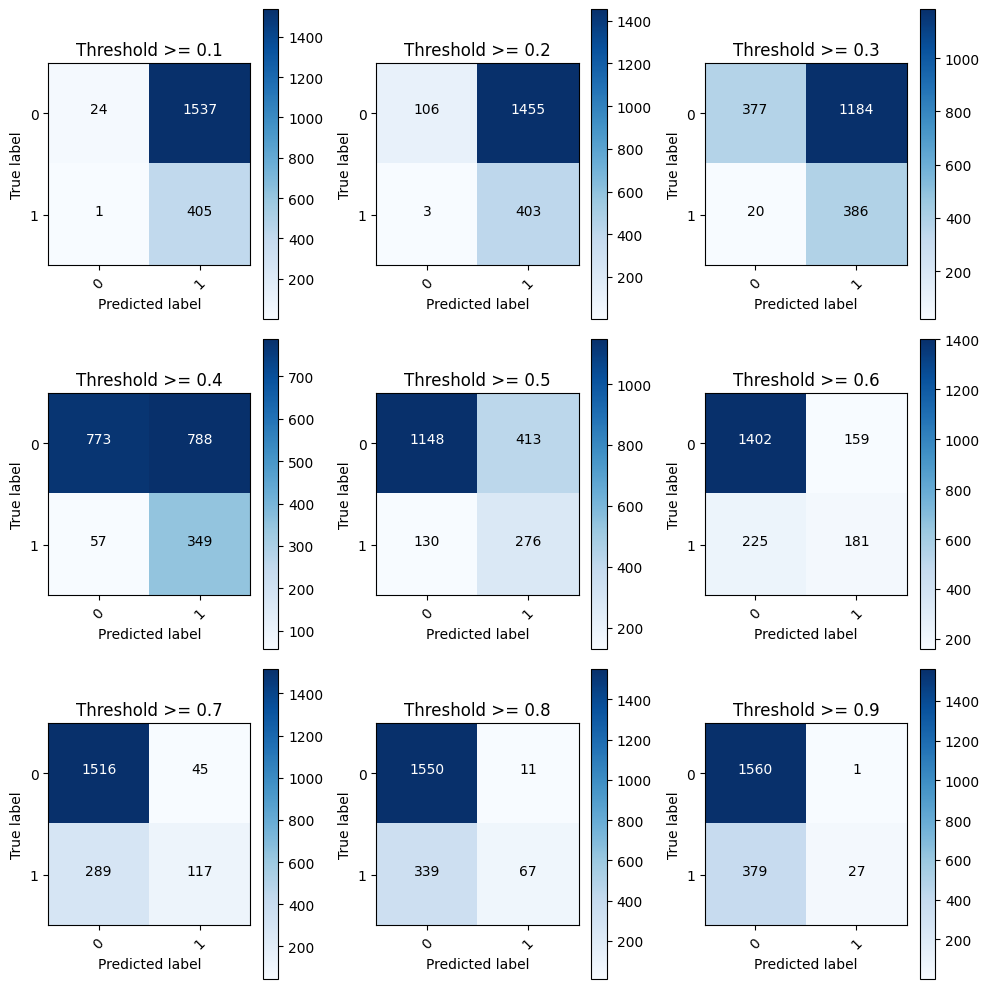

In [62]:
log_reg_6 = LogisticRegression()

# param_grid = [{'C': loguniform.rvs(1e-5, 1, size=10),
#                'max_iter': [500],
#                'class_weight' : ['balanced'],
#                'solver': ['liblinear'],
#                'penalty': ['l1']
#                }]

param_grid = [{'C': [0.005],
               'max_iter': [500],
               'class_weight' : ['balanced'],
               'solver': ['liblinear'],
               'penalty': ['l1']
               }]
            
grid_search = GridSearchCV(log_reg_6, param_grid, cv=5, verbose=1, scoring='recall')

results_log_reg_6 = grid_search.fit(x_train,y_train) ## On f_regression feature selector dataset

# summarize result
print('Best Score: %s' % results_log_reg_6.best_score_)
print('Best Hyperparameters: %s' % results_log_reg_6.best_params_)

y_pred_proba = results_log_reg_6.predict_proba(x_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] >= i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    rec1 = recall_score(y_test, y_test_predictions_high_recall)
    acc= 1.0*(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,0]+cnf_matrix[1,1]+cnf_matrix[0,1])
    print("Recall metric in the testing dataset: ",rec1)
    print("Accuracy score for the testing dataset: ",acc)
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%i)
    print("")

**CatBoost**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.6947003103054059
Best Hyperparameters: {'grow_policy': 'Lossguide', 'max_depth': 8, 'n_estimators': 2000}
Recall metric in the testing dataset:  0.896551724137931
Accuracy score for the testing dataset:  0.9110320284697508
Confusion matrix, without normalization
[[1428  133]
 [  42  364]]

Recall metric in the testing dataset:  0.8497536945812808
Accuracy score for the testing dataset:  0.929334011184545
Confusion matrix, without normalization
[[1483   78]
 [  61  345]]

Recall metric in the testing dataset:  0.8029556650246306
Accuracy score for the testing dataset:  0.9313675648195221
Confusion matrix, without normalization
[[1506   55]
 [  80  326]]

Recall metric in the testing dataset:  0.7438423645320197
Accuracy score for the testing dataset:  0.9252669039145908
Confusion matrix, without normalization
[[1518   43]
 [ 104  302]]

Recall metric in the testing dataset:  0.7068965517241379
Accuracy score for th

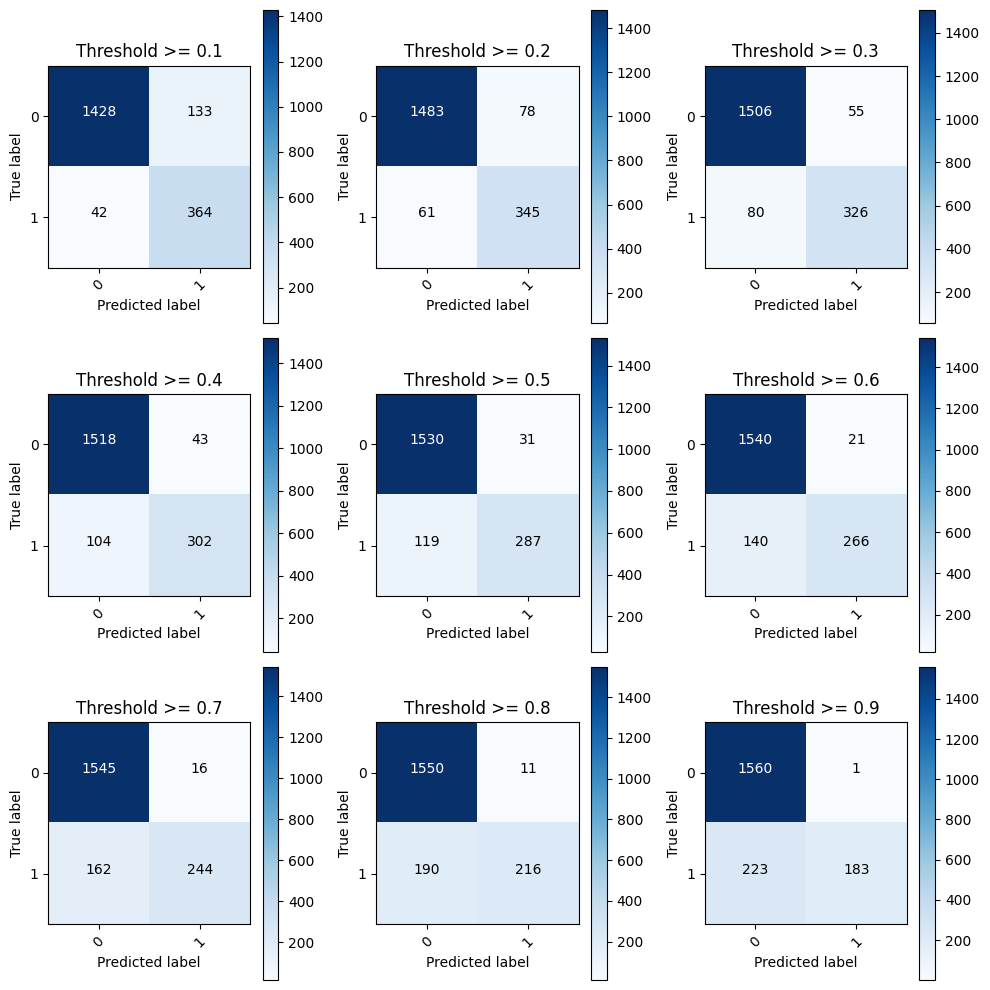

In [63]:
y = credits["BAD"]
x = credits.drop(columns=["BAD"])
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =.33,random_state=1)

cat_boost_6 = catboost.CatBoostClassifier(verbose=False)

# param_grid = [{'C': loguniform.rvs(1e-5, 1, size=10),
#                'max_iter': [500],
#                'class_weight' : ['balanced'],
#                'solver': ['liblinear'],
#                'penalty': ['l1']
#                }]

param_grid = [{
               'n_estimators':[2000], 
               'max_depth':[8],
               'grow_policy':['Lossguide']
               }]
            
grid_search = GridSearchCV(cat_boost_6, param_grid, cv=5, verbose=1, scoring='recall')

results_cat_boost_6 = grid_search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results_cat_boost_6.best_score_)
print('Best Hyperparameters: %s' % results_cat_boost_6.best_params_)

y_pred_proba = results_cat_boost_6.predict_proba(x_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] >= i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    rec1 = recall_score(y_test, y_test_predictions_high_recall)
    acc= 1.0*(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,0]+cnf_matrix[1,1]+cnf_matrix[0,1])
    print("Recall metric in the testing dataset: ",rec1)
    print("Accuracy score for the testing dataset: ",acc)
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%i)
    print("")

**Globally threshold = 0.1 seems like a great choice:**

Recall metric in the testing dataset:  0.896551724137931
Accuracy score for the testing dataset:  0.9110320284697508
Confusion matrix, without normalization
[[1428  133]
 [  42  364]]



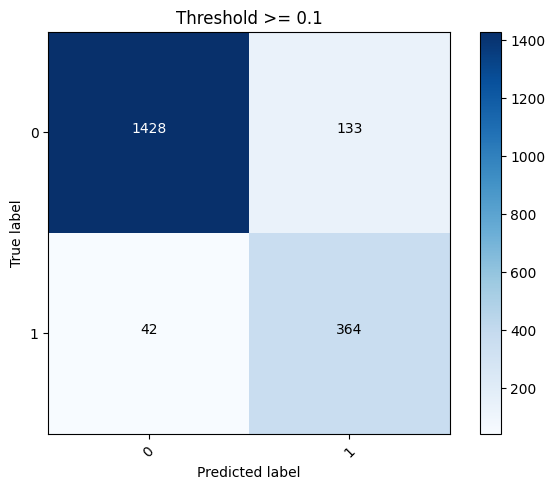

In [64]:
y_test_predictions_high_recall = y_pred_proba[:,1] >= 0.1
plt.plot(3,3,1)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall)
np.set_printoptions(precision=2)
rec1 = recall_score(y_test, y_test_predictions_high_recall)
acc= 1.0*(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,0]+cnf_matrix[1,1]+cnf_matrix[0,1])
print("Recall metric in the testing dataset: ",rec1)
print("Accuracy score for the testing dataset: ",acc)
# Plot non-normalized confusion matrix
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%0.1)
print("")

The retrieved recall and accuracy values fluctuate in accordance with the chosen threshold.

The process of selecting a threshold necessitates a decision based on the specific accuracy and recall values mandated.

In typical scenarios, adhering to the default threshold of 0.5 is recommended.

# Further exploration regarding the utilization of resampling to enhance the recall measure.

As previously noted, resampling can be utilized to enhance the efficacy of machine learning algorithms.

The present approach involves the partitioning of the dataset with the objective of achieving a balanced distribution of the target class at a ratio of 1:1.

The present technique entails the processing of data to achieve a roughly balanced proportion of 50% to 50%.

Two distinct methodologies may be employed to accomplish this task, namely Under-Sampling and Over-Sampling. The methodology of under-sampling will be employed in the present study.

In [65]:
# getting length and indices of minority class.
default_len = len(credits[credits["BAD"]==1])
default_indices = np.array(credits[credits["BAD"]==1].index)

# selecting the same number of elements from majority class randomly.
good_indices = np.array(credits[credits["BAD"]==0].index)
rand_good_indices = np.random.choice(good_indices, default_len, replace = False)
rand_good_indices = np.array(rand_good_indices)

# combing the indices
combined_indices = np.concatenate([rand_good_indices,default_indices])

# getting the corresponding dataset with above indices.
comb_df = credits.iloc[combined_indices,:]
comb_y = comb_df["BAD"]

In [66]:
# using the f_classif feature selection method which produced good results in above cases
comb_x = pd.DataFrame(SelectKBest(f_classif, k=10).fit_transform(comb_df.drop(["BAD"],axis=1),comb_df["BAD"]))
comb_x.head()

,0,1,2,3,4,5,6,7,8,9
0,12100.0,0.0,0.0,262.394254,0.000000,18.430472,0.0,0.0,0.0,0.0
1,13500.0,0.0,0.0,209.460594,3.000000,39.521845,0.0,0.0,0.0,0.0
2,21700.0,0.0,0.0,309.028446,1.186055,33.877264,0.0,0.0,0.0,0.0
3,14300.0,0.0,0.0,217.277192,0.000000,34.095384,0.0,0.0,0.0,0.0
4,23500.0,0.0,0.0,110.057274,0.000000,19.268440,0.0,0.0,0.0,0.0


In [67]:
# spliting the data into train and test datasets
x_trc,x_tec,y_trc,y_tec = train_test_split(comb_x,comb_y,test_size =.33,random_state=1000)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.655
0.6157407407407407
0.6051282051282051
0.6858638743455497

Accuracy Score =  0.70828025477707
F1 Score =  0.7077319780382363
Precision Score =  0.7088727780533006
Recall Score =  0.7078123174009583

Confusion matrix, without normalization
[[295 103]
 [126 261]]


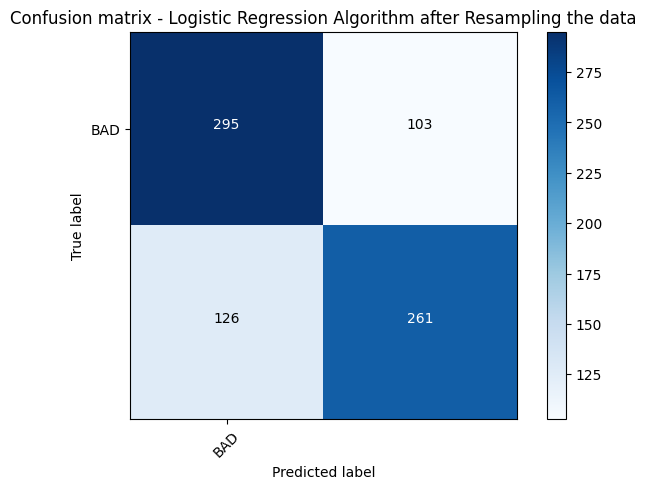

In [68]:
# using Kfold scores to train the data since very less data is available
lr = LogisticRegression()

def printing_Kfold_scores(x_trc,y_trc):
    fold = KFold(4,shuffle=False) 
    for train,test in fold.split(x_trc):  
        x1 = x_trc.iloc[train,:]
        y1 = y_trc.iloc[train]
        x2 = x_trc.iloc[test,:]
        y2 = y_trc.iloc[test]
        lr.fit(x1,y1)
        y_pred_undersample = lr.predict(x2)
        recall_acc = recall_score(y2,y_pred_undersample)
        print(recall_acc)  
        
printing_Kfold_scores(x_trc,y_trc)

y_predr = lr.predict(x_tec)

print("")
print('Accuracy Score = ',accuracy_score(y_tec,y_predr))
print('F1 Score = ',f1_score(y_tec, y_predr, average="macro"))
print('Precision Score = ',precision_score(y_tec, y_predr, average="macro"))
print('Recall Score = ',recall_score(y_tec, y_predr, average="macro"))
print("")
cnf_matrix = confusion_matrix(y_tec, y_predr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Logistic Regression Algorithm after Resampling the data')
plt.show()

0.725
0.7407407407407407
0.7846153846153846
0.7958115183246073

Accuracy Score =  0.7987261146496816
F1 Score =  0.7987179487179488
Precision Score =  0.7987355247442489
Recall Score =  0.7987937101528313

Confusion matrix, without normalization
[[316  82]
 [ 76 311]]


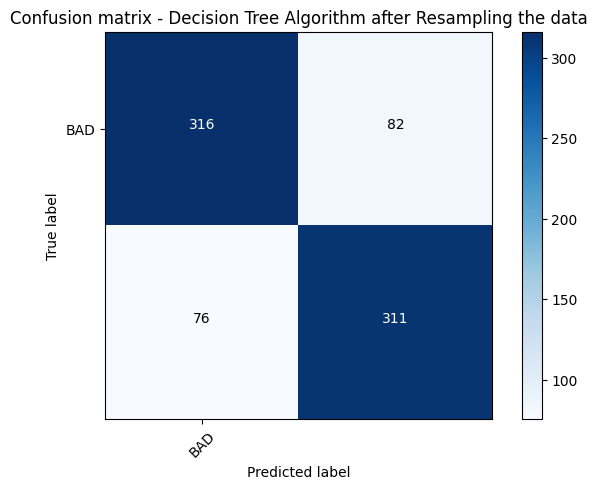

In [69]:
lr = DecisionTreeClassifier()
        
printing_Kfold_scores(x_trc,y_trc)

y_predr = lr.predict(x_tec)
print("")
print('Accuracy Score = ',accuracy_score(y_tec,y_predr))
print('F1 Score = ',f1_score(y_tec, y_predr, average="macro"))
print('Precision Score = ',precision_score(y_tec, y_predr, average="macro"))
print('Recall Score = ',recall_score(y_tec, y_predr, average="macro"))
print("")

cnf_matrix = confusion_matrix(y_tec, y_predr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title='Confusion matrix - Decision Tree Algorithm after Resampling the data')
plt.show()

As evidenced by the findings, the implementation of data resampling in logistic regression has demonstrably resulted in an observed elevation of approximately 5-7% in recall.

The recall metric remains relatively consistent in the context of the Decision Tree Algorithm, LightGBM and CatBoost classifiers as they already incorporate Features Selection.